<a href="https://colab.research.google.com/github/Kazuky1141/Colab_IA/blob/master/ESIS_Inteligencia_Artificial_Unidad_2_Semana_4b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4b. Despliegue de su modelo
Ahora que tenemos un modelo bien entrenado, es hora de utilizarlo. En este ejercicio, expondremos nuevas imágenes a nuestro modelo y detectaremos las letras correctas del alfabeto del lenguaje de signos. ¡Vamos a empezar!

## 4b.1 Objetivos

* Cargar desde disco un modelo ya entrenado
* Reformatear imágenes para un modelo entrenado con imágenes de formato diferente.
* Realizar inferencias con imágenes nuevas, nunca vistas por el modelo entrenado y evaluar su rendimiento.

In [22]:
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.io as tv_io
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

False

## 4b.2 Cargando el Modelo

Ahora que estamos en un nuevo cuaderno, vamos a cargar el modelo guardado que hemos entrenado. Nuestro guardado del ejercicio anterior creó una carpeta llamada «asl_model». Podemos cargar el modelo seleccionando la misma carpeta.

Dado que nuestro modelo utiliza un [módulo personalizado](https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html), necesitaremos cargar el código de esa clase. Hemos guardado una copia del código en [utils.py](./uitls.py).

In [23]:
!apt-get install -y p7zip-full
!wget https://github.com/ichaparroc/IA-EPIS/raw/refs/heads/main/ASL.7z -O ASL.7Z
!7z x ASL.7Z
!rm -f ASL.7Z
!rm -f sign_mnist_train.csv
!rm -f sign_mnist_valid.csv

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
--2025-04-25 22:45:50--  https://github.com/ichaparroc/IA-EPIS/raw/refs/heads/main/ASL.7z
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ichaparroc/IA-EPIS/refs/heads/main/ASL.7z [following]
--2025-04-25 22:45:50--  https://raw.githubusercontent.com/ichaparroc/IA-EPIS/refs/heads/main/ASL.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24400318 (23M) [application/octet-stream]
S

In [24]:
from utils import MyConvBlock

Ahora que tenemos una definición para `MyConvBlock`, podemos usar [torch.load](https://pytorch.org/docs/stable/generated/torch.load.html) para cargar un modelo desde una ruta. Podemos usar `map_location` para especificar el dispositivo. Cuando imprimimos el modelo, ¿se ve igual que en el último cuaderno?

In [25]:
model = torch.load('model.pth', map_location=device, weights_only=False)
model

Sequential(
  (0): MyConvBlock(
    (model): Sequential(
      (0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0, inplace=False)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (1): MyConvBlock(
    (model): Sequential(
      (0): Conv2d(25, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (2): MyConvBlock(
    (model): Sequential(
      (0): Conv2d(50, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0, 

También podemos verificar si el modelo está en nuestra GPU.

In [26]:
next(model.parameters()).device

device(type='cpu')

## 4b.3 Preparar una imagen para el modelo

Ahora es el momento de utilizar el modelo para hacer predicciones sobre nuevas imágenes que nunca ha visto antes. Esto también se llama inferencia. Tenemos un conjunto de imágenes en la carpeta `data/asl_images`. Intenta abrirla utilizando el navegador de la izquierda y explora las imágenes.

Te darás cuenta de que las imágenes que tenemos son de mucha mayor resolución que las imágenes de nuestro conjunto de datos. También son en color. Recuerda que nuestras imágenes en el conjunto de datos eran de 28x28 píxeles y en escala de grises. Es importante tener en cuenta que siempre que hacemos predicciones con un modelo, la entrada debe coincidir con la forma de los datos con los que se entrenó el modelo. Para este modelo, el conjunto de datos de entrenamiento tenía la forma: (27455, 28, 28, 1). Esto correspondía a 27455 imágenes de 28 por 28 píxeles cada una con un canal de color (escala de grises).

### 4b.3.1 Mostrar las imágenes

Cuando utilicemos nuestro modelo para hacer predicciones sobre nuevas imágenes, será útil mostrar también la imagen. Para ello, podemos utilizar la biblioteca matplotlib.

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image, cmap='gray')

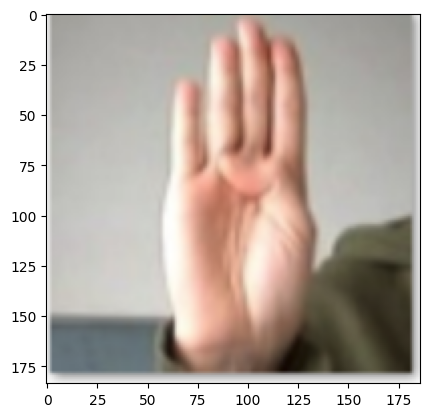

In [28]:
show_image('b.png')

### 4b.3.2 Escalado de las imágenes

Las imágenes de nuestro conjunto de datos eran de 28x28 píxeles y en escala de grises. Necesitamos asegurarnos de pasar el mismo tamaño e imágenes en escala de grises a nuestro método para la predicción. Hay algunas formas de editar imágenes con Python, pero TorchVision también tiene la función [read_image](https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html). Podemos hacerle saber qué tipo de imagen leer con [ImageReadMode](https://pytorch.org/vision/stable/generated/torchvision.io.ImageReadMode.html#torchvision.io.ImageReadMode).

In [29]:
image = tv_io.read_image('b.png', tv_io.ImageReadMode.GRAY)
image

tensor([[[247, 223, 178,  ..., 223, 231, 238],
         [245, 221, 178,  ..., 213, 223, 232],
         [244, 220, 177,  ..., 204, 217, 228],
         ...,
         [247, 243, 238,  ..., 223, 231, 238],
         [249, 246, 243,  ..., 232, 238, 243],
         [250, 248, 246,  ..., 240, 243, 246]]], dtype=torch.uint8)

Fijémonos en la forma de la imagen.

In [30]:
image.shape

torch.Size([1, 184, 186])

Esta imagen es mucho más grande que con la que entrenamos. Podemos utilizar [TorchVision](https://pytorch.org/vision/stable/index.html)'s [Transforms](https://pytorch.org/vision/0.9/transforms.html) de nuevo para obtener los datos en la forma que nuestro modelo espera.

Lo haremos:
* Convertiremos la imagen a float con [ToDtype](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.ToDtype.html)
  * Estableceremos `scale` a `True` para convertir de [0, 255] a [0, 1].
* [Redimensionar](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.Resize.html#torchvision.transforms.v2.Resize) la imagen para que sea de 28 x 28 píxeles
* Convertir las imágenes a [Escala de grises](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.Grayscale.html#torchvision.transforms.v2.Grayscale)
  * Este paso no hace nada ya que nuestros modelos ya están en escala de grises, pero lo hemos añadido aquí para mostrar una forma alternativa de obtener imágenes en escala de grises.

In [31]:
IMG_WIDTH = 28
IMG_HEIGHT = 28

preprocess_trans = transforms.Compose([
    transforms.ToDtype(torch.float32, scale=True), # Converts [0, 255] to [0, 1]
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.Grayscale()  # From Color to Gray
])

Probemos `preprocess_trans` en una imagen para asegurarnos de que funciona correctamente:

In [32]:
processed_image = preprocess_trans(image)
processed_image

tensor([[[0.6960, 0.6279, 0.6348, 0.6493, 0.6584, 0.6599, 0.6638, 0.6630,
          0.6652, 0.6677, 0.6711, 0.6696, 0.6661, 0.6677, 0.7103, 0.6559,
          0.6369, 0.6507, 0.6464, 0.6379, 0.6293, 0.6216, 0.6139, 0.6074,
          0.5984, 0.5895, 0.5836, 0.6977],
         [0.7013, 0.6388, 0.6480, 0.6578, 0.6647, 0.6687, 0.6709, 0.6734,
          0.6746, 0.6794, 0.6814, 0.6784, 0.6902, 0.6801, 0.7648, 0.6606,
          0.5610, 0.6348, 0.6418, 0.6509, 0.6417, 0.6308, 0.6252, 0.6197,
          0.6095, 0.6007, 0.5923, 0.6773],
         [0.7061, 0.6479, 0.6588, 0.6668, 0.6743, 0.6811, 0.6845, 0.6848,
          0.6872, 0.6898, 0.6913, 0.6909, 0.7671, 0.6833, 0.6945, 0.6803,
          0.4720, 0.6061, 0.5686, 0.6548, 0.6566, 0.6471, 0.6380, 0.6273,
          0.6198, 0.6124, 0.6078, 0.6837],
         [0.7165, 0.6603, 0.6699, 0.6770, 0.6821, 0.6880, 0.6959, 0.7001,
          0.7027, 0.7014, 0.7009, 0.7041, 0.8257, 0.6885, 0.6387, 0.7202,
          0.4938, 0.6614, 0.5266, 0.6351, 0.6649, 0.6595,

Los números parecen correctos, pero ¿y la forma?

In [33]:
processed_image.shape

torch.Size([1, 28, 28])

A continuación, vamos a trazar la imagen para ver si se parece a lo que hemos entrenado.

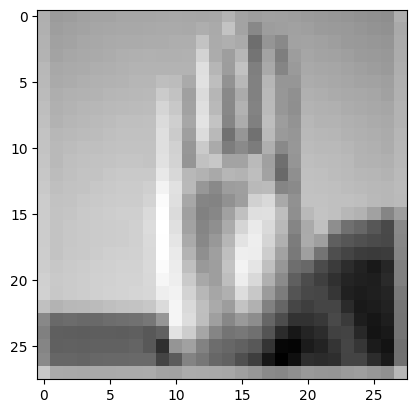

In [34]:
plot_image = F.to_pil_image(processed_image)
plt.imshow(plot_image, cmap='gray')

¡Se ve bien! Pasémoslo a nuestro modelo.

### 4b.4 Hacer predicciones

Bien, ¡ahora estamos listos para predecir! Nuestro modelo sigue esperando un lote de imágenes. Si [squeeze](https://pytorch.org/docs/stable/generated/torch.squeeze.htmlhttps://pytorch.org/docs/stable/generated/torch.squeeze.html) elimina dimensiones de 1, [unsqueeze](https://pytorch.org/docs/stable/generated/torch.unsqueeze.htmlhttps://pytorch.org/docs/stable/generated/torch.unsqueeze.html) añade una dimensión de 1 en el índice que especifiquemos. La primera dimensión suele ser la dimensión del lote, por lo que podemos decir `.unsqueeze(0)`.

In [35]:
batched_image = processed_image.unsqueeze(0)
batched_image.shape

torch.Size([1, 1, 28, 28])

A continuación, debemos asegurarnos de que el tensor de entrada está en el mismo `dispositivo` que el modelo.

In [36]:
batched_image_gpu = batched_image.to(device)
batched_image_gpu.device

device(type='cpu')

Ahora estamos listos para pasarlo al modelo.

In [37]:
output = model(batched_image_gpu)
output

tensor([[-34.5003,  18.2607, -11.7280, -22.3193,  -4.9738, -13.0488,  -8.0585,
         -29.5380, -15.0260, -16.6386, -18.8668, -10.8197, -26.3653, -27.8140,
         -13.0507, -18.5632, -12.5391, -36.5896, -15.2774,   6.6090, -16.9730,
           2.8577,  -4.3758, -35.1439]], grad_fn=<AddmmBackward0>)

### 4b.4.1 Comprender la predicción

Las predicciones tienen el formato de una matriz de 24 longitudes. Cuanto mayor sea el valor, más probable es que la imagen de entrada pertenezca a la clase correspondiente. Hagámoslo un poco más legible. Podemos empezar por encontrar qué elemento de la matriz representa la mayor probabilidad. Esto puede hacerse fácilmente con la biblioteca numpy y la función [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html).

In [38]:
prediction = output.argmax(dim=1).item()
prediction

1

Cada elemento de la matriz de predicción representa una letra posible del alfabeto de la lengua de signos. Recuerda que j y z no son opciones porque implican mover la mano, y sólo estamos tratando con fotos fijas. Creemos una correspondencia entre el índice de la matriz de predicciones y la letra correspondiente.

In [39]:
# Alphabet does not contain j or z because they require movement
alphabet = "abcdefghiklmnopqrstuvwxy"

Ahora podemos pasar nuestro índice de predicción para encontrar la letra correspondiente.

In [40]:
alphabet[prediction]

'b'

#### Ejercicio: Póngalo todo junto

Pongamos todo en una función para que podamos hacer predicciones sólo a partir del archivo de imagen. Impleméntalo en la función de abajo usando las funciones y pasos anteriores. Si necesitas ayuda, puedes revelar la solución haciendo clic en los tres puntos de abajo.

In [41]:
def predict_letter(file_path):
    # Show image
    show_image(file_path)
    # Load and grayscale image
    image = tv_io.read_image(file_path, tv_io.ImageReadMode.GRAY)
    # Transform image
    IMG_WIDTH = 28
    IMG_HEIGHT = 28
    preprocess_trans = transforms.Compose([
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
        transforms.Grayscale()
    ])
    image = preprocess_trans(image)
    # Batch image
    image = image.unsqueeze(0)
    # Send image to correct device
    image = image.to(device)
    # Make prediction
    output = model(image)
    # Find max index
    prediction = output.argmax(dim=1).item()
    # Convert prediction to letter
    alphabet = "abcdefghiklmnopqrstuvwxy"
    predicted_letter = alphabet[prediction]
    # Return prediction
    return predicted_letter

Predicción para 'b.png': b


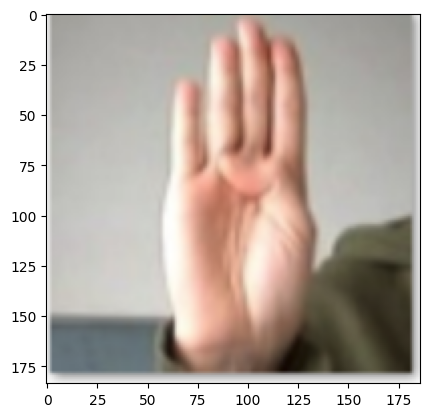

In [42]:
print("Predicción para 'b.png':", predict_letter("b.png"))

Utilicemos también la función con la letra 'a' en el datset asl_images:

Predicción para 'a.png': a


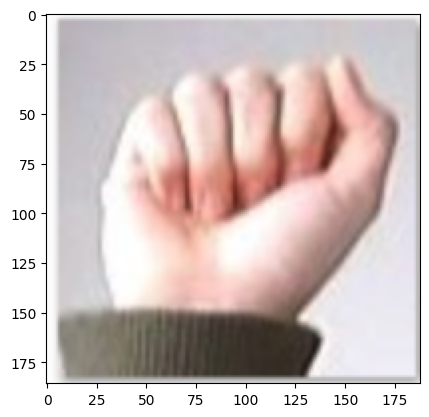

In [43]:
print("Predicción para 'a.png':", predict_letter("a.png"))

## 4b.5 Resumen

Buen trabajo con estos ejercicios. Has pasado por todo el proceso de entrenamiento de un modelo de alta precisión desde cero, y luego has utilizado el modelo para hacer nuevas y valiosas predicciones. Si tienes algo de tiempo, te animamos a que tomes fotos con tu webcam, las subas soltándolas en la carpeta data/asl_images, y pruebes el modelo con ellas. Para Mac puedes utilizar Photo Booth. Para Windows puedes seleccionar la aplicación Cámara en la pantalla de inicio. Esperamos que lo pruebes. Es una buena oportunidad para aprender algo de lenguaje de signos. Por ejemplo, prueba con las letras de tu nombre.

Podemos imaginar cómo se podría utilizar este modelo en una aplicación para enseñar a alguien el lenguaje de signos, o incluso ayudar a alguien que no puede hablar a interactuar con un ordenador.

# Preguntas

1. ¿Por qué es importante que las imágenes utilizadas para hacer predicciones tengan el mismo formato (dimensiones y color) que las imágenes con las que se entrenó el modelo?

2. Describe los pasos necesarios para procesar una imagen antes de hacer una predicción con el modelo entrenado. ¿Qué transformaciones se deben aplicar?

3. ¿Qué es la "dimensión del lote" (batch) y por qué es necesario agregarla cuando hacemos predicciones con el modelo?

4. ¿Cómo interpreta el modelo las predicciones que genera? Explica el formato de salida y cómo se convierte en una letra del alfabeto de lengua de signos.